# Recurrent Neural network

This is my take on the code provided below. 

## Data Preparation

The main code execution starts by downloading the files of the book from s3. 
```
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
```
calls load_data_time_machine which loads the sequence into memory using SeqDataLoader

SequenceDataLoader has a init function which downloads data using load_corpus_time_machine function which basically reads into a array of line (read_time_machine) and tokenizes the data (tokenize(lines, "char")). 

There are 2 options provided for tokenization 'char' and 'word'. After this we create a vocabulary for the input book, which is based on tokenization type using Vocab class (2 attributes list of tokens from indexs and list of indexs from tokens). Which in its init calls count_corpus(tokens) to create a collection counter which tracks the frequency of all tokens. 
Then we sort it on descending order. Then we extract all unique tokens which are greater than a minimum frequency and create a dict() and array with dict key=token and value=index of the token in array.

In [371]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

import collections
import re
import random
import os
import requests
import hashlib
import time

np.random.seed(seed=1)
torch.manual_seed(1)
# !mkdir figures # for saving plots

mkdir: figures: File exists


# Data Preparation
## Assumptions
1. We are considering default vocab of type 'char'(letters) so this creates a counter of max A to Z (32) in total but here the book contains only 28 char used.
2. We create vocab based on frequency of letters and then sort it in descending order so maximum times a letter occur appears first as a token.
3. Tokens with max frequency appear first
4. Since the length of the input is in letters we use same as length of output 

In [372]:
class SeqDataLoader:
    """An iterator to load sequence data."""

    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)


class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ["<unk>"] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [373]:
def tokenize(lines, token="word"):
    """Split text lines into word or character tokens."""
    if token == "word":
        return [line.split() for line in lines]
    elif token == "char":
        return [list(line) for line in lines]
    else:
        print("ERROR: unknown token type: " + token)


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1) :]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos : pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i : i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    # print corpus
    # print(corpus)
    Xs = torch.tensor(corpus[offset : offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1 : offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i : i + num_steps]
        Y = Ys[:, i : i + num_steps]
        yield X, Y

In [374]:
def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download("time_machine"), "r") as f:
        lines = f.readlines()
    return [re.sub("[^A-Za-z]+", " ", line).strip().lower() for line in lines]


def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, "char")
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab


def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [375]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"
DATA_HUB["time_machine"] = (DATA_URL + "timemachine.txt", "090b5e7e70c295757f55df93cb0a180b9691891a")

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
# print(len(vocab))
# for values in zip(train_iter.vocab,train_iter.corpus):
#     print(values)

# Model

In [376]:
# Create the initial parameters


def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [377]:
# Create the initial state
# We assume this is a tuple of one element (later we will use longer tuples)
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

## Shapes of variables and parameters used
For the 1st step
```
X :  torch.Size([2, 28])
W_xh :  torch.Size([28, 512])
H (from state/ before execution) :  torch.Size([2, 512])
W_hh :  torch.Size([512, 512])
H (after execution):  torch.Size([2, 512])
W_hq :  torch.Size([512, 28])
b_q :  torch.Size([28])
Y :  torch.Size([2, 28])
```

In [378]:
# Forward function.
# Input sequence is (T,B,V), where T is length of the sequence, B is batch size, V is vocab size.
# We iterate over each time step, and process the batch (for that timestep in parallel).
# Output sequence is (T*B, V), since concatante all the time steps.
# We also return the final state, so we can process the next subsequence.


def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    (H,) = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        # print('X : ',X.shape)
        # print('W_xh : ',W_xh.shape)
        # print('H : ',H.shape)
        # print('W_hh : ',W_hh.shape)
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        # print('H : ',H.shape)
        # print('W_hq : ',W_hq.shape)
        # print('b_q : ',b_q.shape)
        Y = torch.mm(H, W_hq) + b_q
        # print('Y : ',Y.shape)
        outputs.append(Y)
        # print('outputs : ',outputs)
    return torch.cat(outputs, dim=0), (H,)

In [379]:
# Make the model class
# Input X to call is (B,T) matrix of integers (from vocab encoding).
# We transpse this to (T,B) then one-hot encode to (T,B,V), where V is vocab.
# The result is passed to the forward function.
# (We define the forward function as an argument, so we can change it later.)


class RNNModelScratch:
    """A RNN Model implemented from scratch."""

    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [380]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device("cpu")

In [381]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), get_params, init_rnn_state, rnn)

### Analysis
Here init state is created using total_no_hidden * batch_size. Which defines state as <2,512>

In [382]:
X = torch.arange(10).reshape((2, 5))  # batch 2, sequence length is 5
state = net.begin_state(X.shape[0], try_gpu())
temp = F.one_hot(X.T, len(vocab)).type(torch.float32)
# print(temp.shape)
# print(X.shape)
# print(net.params[0].shape)
# print(net.params[2].shape)
# print(len(state))  # length 1
# print(state[0].shape)  # (2,512)

Y, new_state = net(X.to(try_gpu()), state)
print(len(vocab))  # 28
print(Y.shape)  # (2x5, 28)

# for X, Y in train_iter:
#     print("X : ",X)
#     print("Y : ",Y)


28
torch.Size([10, 28])


# Prediction (Generation)

## Predict function assumptions
1. we consider only 1 letter of the prefix provided
2. input shape will only be of 1x1 size


In [383]:
def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # print(outputs)
    # print(get_input().shape)
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return "".join([vocab.idx_to_token[i] for i in outputs])

In [384]:
# sample 10 characters after the prefix.
# since the model is untrained, the results will be garbage.
predict("time traveller ", 10, net, vocab, try_gpu())

'time traveller ndbfjfjfjf'

# Training

## Assumptions
1. Gradient clipping else statement to assign if gradient not required doesn't make sense

In [385]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # l2 norm
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    # clipping if it exceeds theta
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Plotting

In [386]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        # print('Animator X : ',x)
        # print('Animator Y : ',y)
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        # print('Accumulator args : ',float(args[0]),float(args[1]))
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # print('Accumulator data : ',self.data)

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training Cycle

## Assumptions
1. Random sampling is not used
2. Teacher forcing : Here we are using the input data as output itself so the next element of the input is treated as output for the previous element. So the train_iter uses following code to set X and Y:
    ```
    Xs = torch.tensor(corpus[offset : offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1 : offset + 1 + num_tokens])
    ```
3. We use **perplexity** to measure the performance. which is just the exponential of the average per token negative log likelihood

In [387]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)  # (B,T) -> (T,B)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # batch_size=1 since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [388]:
def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel="epoch", ylabel="perplexity", legend=["train"], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)
    num_preds = 50
    predict_ = lambda prefix: predict(prefix, num_preds, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict_("time traveller"))
            animator.add(epoch + 1, [ppl])
    print(f"perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}")
    print(predict_("time traveller"))
    print(predict_("traveller"))

## Execution

perplexity 1.0, 85997.6 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


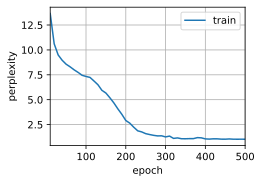

In [389]:
num_epochs, lr = 500, 1
device = try_gpu()
torch.manual_seed(42)
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn)
train(net, train_iter, vocab, lr, num_epochs, try_gpu())

In [390]:
num_preds = 100
predict_ = lambda prefix: predict(prefix, num_preds, net, vocab, device)

print(predict_("time traveller"))
print(predict_("the"))

time travelleryou can show black is white by argument said filby but you willnever convince mepossibly not said th
ther a large thing to expect us to begin uponsaid filby an argumentative person with red hairi do not m


In [391]:
num_preds = 500
predict_ = lambda prefix: predict(prefix, num_preds, net, vocab, device)

print(predict_("the"))

ther a large thing to expect us to begin uponsaid filby an argumentative person with red hairi do not mean to ask you to accept anything without reasonableground for it you will soon admit as much as i need from you youknow of course that a mathematical line a line of thickness nilhas no real existroug redereas th the atleprofeme trevellin wew andimen io a tine and twallllishbous im the bey ho gon anowher a ceallict suif on chivel to back fon ang browt hog ano ter it you time tramelleryou can show 
